In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
P_CONTAGION = 0.2
P_ASYMPTOMATIC = 0.85
P_SICK_BAD = .1
P_DEATH = .01
# R_HEALTHY_CARRIER = 0.1
# R_SICK = 0.1
# R_SICK_BAD = 0.1
# R_DEATH = 0
DISEASE_DAYS = 28
ASYMPTOMATIC_DAYS =14

In [66]:
class Cluster(object):
    def __init__(self, healthy_carrier, sick, sick_bad, dead, recovered):
        self.healthy_carriers = [healthy_carrier]  # List<>time series ratios of healthy carriers
        self.sicks = [sick] # List<>  (does not include sicks bad)
        self.sicks_bad = [sick_bad]
        self.deads = [dead]
        self.recovereds = [recovered]

In [67]:
# closed cluster:
class Contamination(object):
    def __init__(self):
        pass
    
    def get_healthy_carrier(self, c):
        """return: healthy_carrier at day n+1"""
        # ratio of people that are contagious
        r_contagious = c.healthy_carriers[-1] + c.sicks[-1]
        p_contagion = r_contagious * P_CONTAGION # probability of contagion
        
        r_at_risk = (1 - c.healthy_carriers[-1] - c.sicks[-1] - c.sicks_bad[-1] - c.deads[-1] - c.recovereds[-1]) 
        r = r_at_risk * p_contagion + c.healthy_carriers[-1]
        
        if len(c.healthy_carriers) > DISEASE_DAYS:
            r -= c.healthy_carriers[-DISEASE_DAYS]  # people recovered, yay!
        return min(max(r,0),1)
    
    def get_sick(self, c):
        r = c.sicks[-1]
        if len(c.sicks) > DISEASE_DAYS:
            r -= c.sicks[-DISEASE_DAYS]  # people recovered or died
        if len(c.healthy_carriers) > ASYMPTOMATIC_DAYS:  # asymptomatic become sick
            r += c.healthy_carriers[-ASYMPTOMATIC_DAYS] * (1- P_ASYMPTOMATIC) * (1-P_SICK_BAD)
        return min(max(r,0),1)

    def get_sick_bad(self, c):
        r = c.sicks_bad[-1]
        if len(c.sicks_bad) > DISEASE_DAYS:
            r -= c.sicks_bad[-DISEASE_DAYS]  # people recovered or died
        if len(c.healthy_carriers) > ASYMPTOMATIC_DAYS:  # asymptomatic become sick
            r += c.healthy_carriers[-ASYMPTOMATIC_DAYS] * (1- P_ASYMPTOMATIC) * P_SICK_BAD
        return min(max(r,0),1)

    def get_dead(self, c):
        r = c.deads[-1] + c.sicks_bad[-1] * P_DEATH
        return min(max(r,0),1)
    
    def get_recovered(self, c):
        """Assume recovered people cannot get sick again."""
        r = c.recovereds[-1]
        if len(c.sicks) > DISEASE_DAYS:
            r += c.sicks[-DISEASE_DAYS]
            r += c.sicks_bad[-DISEASE_DAYS] * (1-P_DEATH)
            r += c.healthy_carriers[-DISEASE_DAYS]
        return min(max(r,0),1)

    def contaminate(self, c):
        """Evolution from D-Day to next day."""
        healthy_carrier = self.get_healthy_carrier(c)
        sick = self.get_sick(c)
        sick_bad = self.get_sick_bad(c)
        dead = self.get_dead(c)
        recovered = self.get_recovered(c)
        
        c.healthy_carriers.append(healthy_carrier)
        c.sicks.append(sick)
        c.sicks_bad.append(sick_bad)
        c.deads.append(dead)
        c.recovereds.append(recovered)
        return c

In [68]:
contamination = Contamination()
c = Cluster(healthy_carrier=.0001, sick=0, sick_bad=0, dead=0, recovered=0)

In [69]:
for i in range(90):
    c = contamination.contaminate(c)

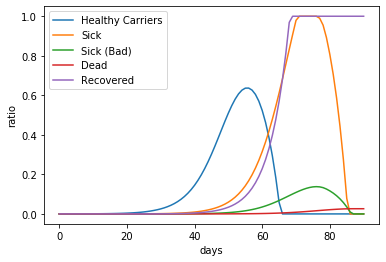

In [70]:
plt.plot(c.healthy_carriers)
plt.plot(c.sicks)
plt.plot(c.sicks_bad)
plt.plot(c.deads)
plt.plot(c.recovereds)

plt.ylabel("ratio")
plt.xlabel("days")
plt.legend(['Healthy Carriers', 'Sick', 'Sick (Bad)', 'Dead', 'Recovered'], loc='upper left')
